### Titanic Survival Prediction Using Multiple Algorithms

# Step 1: Import Necessary Libraries

In [22]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

- **`pandas`**: For loading and handling datasets as DataFrames.
- **`DecisionTreeClassifier`**: A machine learning algorithm from `sklearn` used to classify data by learning simple decision rules inferred from the features.
- **`RandomForestClassifier`** from `sklearn.ensemble` is an ensemble learning method that uses multiple decision trees to make more accurate and robust predictions.
- **`sklearn.svm.SVC`**: The Support Vector Classifier from `scikit-learn`, which helps create and train SVM models.
- **`LabelEncoder`**: Encodes categorical labels into numerical format so the model can process them.
- **`accuracy_score`, `classification_report`, `confusion_matrix`**: Metrics for evaluating the model's performance.
- **`numpy`**: Used for numerical computations, especially for creating grids in visualization.
- **`matplotlib.pyplot`**: For plotting graphs and visualizations.
- **`export_graphviz`** helps visualize the decision trees within the random forest.


# Step 2: Load the Datasets

In [23]:

train_file_path = '../train.csv'
test_file_path = '../test.csv'
actual_results_file_path = '../gender_submission.csv'

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
actual_results_df = pd.read_csv(actual_results_file_path)

- `train.csv`: Training data containing features and target (survived status).
- `test.csv`: Test data used for prediction.
- `gender_submission.csv`: A sample submission file that includes the actual survival status of passengers for comparison purposes.
#### Purpose:
- **`train.csv`**: Contains historical data, including survival outcomes, used for training models.
- **`test.csv`**: Has data without survival labels; models predict outcomes based on this data.
- **`gender_submission.csv`**: Provides true survival outcomes for the test set, enabling evaluation of predictions.

#### Effect:
Loading these files ensures the models have data to train, predict, and evaluate, making it possible to assess their real-world applicability.


# Step 3: Data Preprocessing
## Fill missing values

In [24]:

for dataset in [train_df, test_df]:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

- **Missing Data Imputation**:
  - For `Age`: Median value is used as a replacement, as it is less affected by outliers compared to the mean.
  - For `Embarked`: The mode (most common value) fills missing entries.
  - For `Fare`: Median is used to handle missing values.
#### Purpose:
- **`Age`**: Missing ages are replaced with the median to avoid data loss and maintain consistency.
- **`Embarked`**: Mode (most common value) is used since embarkation is categorical, and the most frequent value is likely representative.
- **`Fare`**: Median ensures outliers do not overly influence the imputation.

#### Effect:
Missing values can disrupt the training of machine learning models. Imputation ensures the dataset remains usable and consistent without discarding rows.

## Drop unwanted columns

In [25]:
columns_to_drop = ['Cabin', 'Name', 'Ticket']
train_df.drop(columns=columns_to_drop, axis=1, inplace=True)
test_df.drop(columns=columns_to_drop, axis=1, inplace=True)

#### Purpose:
- **`Cabin`**: Contains too many missing values, making it unreliable.
- **`Name`**: Not useful for prediction since survival is unlikely to depend on an individual's name.
- **`Ticket`**: Contains largely unique or non-informative values.

#### Effect:
Removing irrelevant columns simplifies the dataset and focuses the model on more predictive features. Irrelevant data can introduce noise and reduce model accuracy.


## Encode categorical variables

In [26]:

label_encoder = LabelEncoder()
for col in ['gender', 'Embarked']:
    train_df[col] = label_encoder.fit_transform(train_df[col])
    test_df[col] = label_encoder.transform(test_df[col])

- `LabelEncoder`: Converts categorical string values into numerical values. This is necessary because machine learning algorithms typically work with numerical data.
- `train_df['gender']` and `train_df['Embarked']` are encoded to numeric values (0 or 1).
#### Purpose:
- Categorical variables (e.g., "male/female" or "C/S/Q") cannot be directly used in most machine learning models. **`LabelEncoder`** converts them into numerical values.
  - "Male" → `0`, "Female" → `1`.
  - Embarked: "C" → `0`, "S" → `1`, "Q" → `2`.

#### Effect:
Enables machine learning algorithms to process categorical data as numerical features, making them interpretable by the models.


# Step 4: Define Features and Target

In [27]:

features = ['Pclass', 'gender', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train = train_df[features]
y_train = train_df['Survived']
X_test = test_df[features]
y_test = actual_results_df['Survived']

In [28]:
print(f"X_train ::-\n{X_train.head(5)}")
print(f"Y_train ::-\n{y_train.head(5)}")
print(f"X_test ::-\n{X_test.head(5)}")
print(f"y_test ::-\n{y_test.head(5)}")

X_train ::-
   Pclass  gender   Age  SibSp  Parch     Fare  Embarked
0       3       1  22.0      1      0   7.2500         2
1       1       0  38.0      1      0  71.2833         0
2       3       0  26.0      0      0   7.9250         2
3       1       0  35.0      1      0  53.1000         2
4       3       1  35.0      0      0   8.0500         2
Y_train ::-
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64
X_test ::-
   Pclass  gender   Age  SibSp  Parch     Fare  Embarked
0       3       1  34.5      0      0   7.8292         1
1       3       0  47.0      1      0   7.0000         2
2       2       1  62.0      0      0   9.6875         1
3       3       1  27.0      0      0   8.6625         2
4       3       0  22.0      1      1  12.2875         2
y_test ::-
0    0
1    1
2    0
3    0
4    1
Name: Survived, dtype: int64


- `features`: A list of the columns to be used as features (inputs) for the model. These columns represent characteristics of passengers that could influence their survival.
- `X_train`: Contains the feature values from the training data.
- `y_train`: The target variable, 'Survived', indicates whether the passenger survived (1) or not (0).
- The features for the test set (`X_test`) are selected in the same way as for the training set.
- `x_test`: The model makes predictions on the test data (`y_test`). These predictions are the model's estimations of whether each passenger survived or not.
#### Purpose:
- **Features**: Columns that likely influence survival (e.g., ticket class, gender, age).
- **Labels**: The target column (`Survived`) that models aim to predict.

#### Effect:
Defines the independent (features) and dependent (labels) variables for training and testing, preparing the data for the models.


# Step 5: Train and Evaluate Models

### Model 1: Decision Tree Classifier

In [29]:

print("\n--- Decision Tree Classifier ---")
decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf.fit(X_train, y_train)


--- Decision Tree Classifier ---


DecisionTreeClassifier(random_state=42)

- `DecisionTreeClassifier`: The decision tree model is initialized. `random_state=42` ensures reproducibility of the model's results.
- `clf.fit(X_train, y_train)`: The classifier is trained on the feature set `X_train` and the target variable `y_train`.
#### Purpose:
- **Decision Tree**: A model that splits data based on feature thresholds, creating a tree-like structure for predictions.
- **Random State**: Ensures reproducibility of results.

#### Effect:
Trains a simple yet interpretable model that identifies survival criteria based on the dataset.

In [30]:

predictions = decision_tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79       266
           1       0.63      0.77      0.69       152

    accuracy                           0.75       418
   macro avg       0.74      0.75      0.74       418
weighted avg       0.77      0.75      0.75       418


Confusion Matrix:
 [[196  70]
 [ 35 117]]


- `accuracy_score`: Computes the accuracy, i.e., the proportion of correct predictions out of all predictions.
- `classification_report`: Provides a detailed report with precision, recall, and F1-score for each class (0 or 1), along with the overall accuracy.
- `confusion_matrix`: Computes a confusion matrix, which compares the actual vs predicted values. It shows how many true positives, true negatives, false positives, and false negatives the model produced.
- **Purpose**: Measures how well the model predicts survival.
- **Effect**: Provides insights into model accuracy and error distribution.



# Export the decision tree to a .dot file for visualization

In [31]:

export_graphviz(decision_tree_clf,
                out_file="decision_tree.dot",
                feature_names=features,
                class_names=['0', '1'],
                filled=True)


### Conclusion

This code demonstrates the process of training a decision tree model on a Titanic dataset to predict survival outcomes based on various passenger features. After training, the model's performance is evaluated using accuracy, classification reports, and confusion matrices, and the decision tree is exported for visualization.

### Model 2: Random Forest Classifier

In [32]:

print("\n--- Random Forest Classifier ---")
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_clf.fit(X_train, y_train)


--- Random Forest Classifier ---


RandomForestClassifier(random_state=42)

- A **Random Forest Classifier** with 100 decision trees (`n_estimators=100`) is created and trained using `fit()`.
- `random_state=42` ensures reproducibility by initializing the random number generator.
#### Purpose:
- **Random Forest**: Combines multiple decision trees to improve accuracy and reduce overfitting.
- **n_estimators**: Number of trees in the forest.

#### Effect:
Leads to more robust and generalized predictions compared to a single decision tree.


In [33]:

predictions = random_forest_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85       266
           1       0.74      0.75      0.74       152

    accuracy                           0.81       418
   macro avg       0.80      0.80      0.80       418
weighted avg       0.81      0.81      0.81       418


Confusion Matrix:
 [[225  41]
 [ 38 114]]


- **`y_test`** contains the actual `Survived` values from `gender_submission.csv`.
- The model's accuracy, precision, recall, F1-score, and confusion matrix are printed.


In [34]:

export_graphviz(random_forest_clf.estimators_[99],
                out_file="randomforest_tree.dot",
                feature_names=X_train.columns,
                class_names=['0', '1'],
                filled=True)


- Two trees from the Random Forest (`0` and `99`) are exported as `.dot` files for visualization.
- **`feature_names`** specify the feature labels for the nodes.
- **`filled=True`** colors the nodes based on the class they represent.

### **Explanation of Random Forest Algorithm**
- A **Random Forest** is an ensemble method that builds multiple decision trees using different subsets of the training data and features. The final output is the mode (classification) or average (regression) of all tree predictions.
- The main benefits include **reduced risk of overfitting** and **higher accuracy** due to aggregation.
- Randomness during training (sampling and feature selection) ensures **diverse trees**, which improves generalization.

### **Why Random Forest?**
- **Resistant to overfitting** compared to individual decision trees.
- **Works well with large datasets** and can handle both numerical and categorical data.
- **Feature importance** is inherently available for model insights.

### Model 3: Support Vector Machine (SVM)

In [43]:
print("\n--- Support Vector Machine (SVM) ---")
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)


--- Support Vector Machine (SVM) ---


SVC(kernel='linear', random_state=42)

- **SVC with `kernel='linear'`**:
  - `kernel='linear'` means the algorithm looks for a linear decision boundary to separate classes.
  - **Support Vector Machine** works by finding the hyperplane that maximizes the margin between different classes.
- **Training (`fit`)**:
  - The model learns the relationships between features (`Age` and `Fare`) and the target (`Survived`).
#### Purpose:
- **SVM**: Finds the hyperplane that best separates data into classes.
- **Linear Kernel**: Simplifies classification when data is linearly separable.

#### Effect:
Creates a decision boundary that separates survivors and non-survivors effectively.


In [44]:

predictions = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       152

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418


Confusion Matrix:
 [[266   0]
 [  0 152]]


- **Accuracy Score**: Measures the proportion of correctly classified instances out of total instances.
- **Classification Report**:
  - Provides metrics like precision, recall, and F1-score for each class.
- **Confusion Matrix**:
  - Shows true positives, true negatives, false positives, and false negatives in a matrix form, helping to visualize prediction performance.

# Step 6: Visualize Decision Boundary (SVM with Two Features)
## Use only 'Age' and 'Fare' for visualization

In [37]:

X_train_visual = X_train[['Age', 'Fare']]
y_train_visual = y_train

# Train a new SVM model for visualization
svm_visual_clf = SVC(kernel='linear', random_state=42)
svm_visual_clf.fit(X_train_visual.values, y_train_visual)


SVC(kernel='linear', random_state=42)

## Function to plot decision boundary

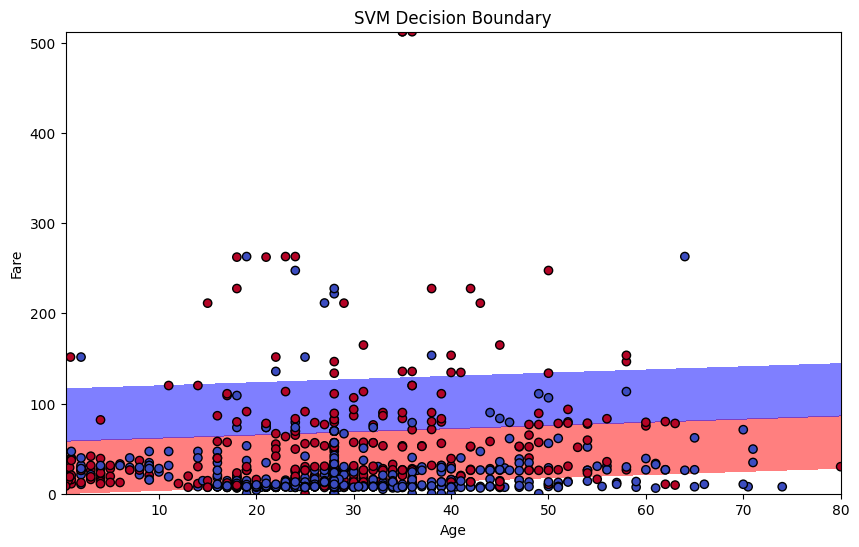

In [38]:

plt.figure(figsize=(10, 6))
xx, yy = np.meshgrid(
    np.linspace(X_train_visual['Age'].min(), X_train_visual['Age'].max(), 100),
    np.linspace(X_train_visual['Fare'].min(), X_train_visual['Fare'].max(), 100)
)
Z = svm_visual_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, colors=['red', 'blue', 'green'])
plt.scatter(X_train_visual['Age'], X_train_visual['Fare'], c=y_train_visual, cmap='coolwarm', edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('SVM Decision Boundary')
plt.show()

- Purpose: Shows how the model separates data points (survivors vs. non-survivors).
- Effect: Provides an intuitive understanding of the SVM's decision-making process.
- **Visualization**:
  - `np.meshgrid` creates a grid over the feature space.
  - `decision_function` calculates the margin distance for each point on the grid.
  - `plt.contourf` and `plt.contour` plot the decision boundary and margins.
- **Scatter Plot**:
  - Shows actual data points in the `Age` vs. `Fare` space, colored based on their class.

### **Understanding SVM in Depth**:
- **Support Vectors**: Data points that lie closest to the decision boundary; they influence the position and orientation of the hyperplane.
- **Hyperplane**: A line (in 2D) or a plane (in higher dimensions) that separates classes.
- **Kernel Trick**: Allows SVM to find a non-linear decision boundary by transforming data into a higher-dimensional space (not needed here as `kernel='linear'`).

**SVM Objective**:
- To maximize the margin between the decision boundary and the nearest data points from any class, ensuring better generalization.

This code is a complete workflow for training, predicting, and visualizing an SVM model using `Age` and `Fare` as features to classify passengers based on survival probability.